# Test workflow in and from within R

In [5]:
getwd()
R.Version()$version.string
# system call function wrapper
s <- function(x, e = F) {
    redir <- if (e) { "2>&1" } else { "" }
    res <- system(paste(x, redir), intern=TRUE)
    if (length(res) > 1) { cat(res, sep='\n') }
}
library(magrittr)

[1] "/home/clemens/agora/paagen/playground"

[1] "R version 4.0.4 (2021-02-15)"

In [2]:
dir.create("data")

Warning message in dir.create("data"):
“'data' already exists”


In [55]:
s('trident fetch -d data -f "*2012_PattersonGenetics*"')

In [4]:
janno_raw <- poseidonR::read_janno("data/2012_PattersonGenetics")

Validating .janno files...

No issues with these .janno files

Reading .janno files...



In [5]:
names(janno_raw)

[1] "source_file"           "Individual_ID"         "Collection_ID"        
 [4] "Source_Tissue"         "Country"               "Location"             
 [7] "Site"                  "Latitude"              "Longitude"            
[10] "Date_C14_Labnr"        "Date_C14_Uncal_BP"     "Date_C14_Uncal_BP_Err"
[13] "Date_BC_AD_Median"     "Date_BC_AD_Start"      "Date_BC_AD_Stop"      
[16] "Date_Type"             "No_of_Libraries"       "Data_Type"            
[19] "Genotype_Ploidy"       "Group_Name"            "Genetic_Sex"          
[22] "Nr_autosomal_SNPs"     "Coverage_1240K"        "MT_Haplogroup"        
[25] "Y_Haplogroup"          "Endogenous"            "UDG"                  
[28] "Library_Built"         "Damage"                "Xcontam"              
[31] "Xcontam_stderr"        "mtContam"              "mtContam_stderr"      
[34] "Primary_Contact"       "Publication_Status"    "Note"                 
[37] "Keywords"

In [6]:
library(magrittr)
# Nr_autosomal_SNPs: should be >= 20000 SNPs
janno_QC <- janno_raw %>% dplyr::filter(
  Nr_autosomal_SNPs >= 20000
)
# Xcontam: if male, then should not be higher then 10%
janno_QC <- janno_QC %>% dplyr::filter(
  is.na(Xcontam) | Genetic_Sex == "F" | (Genetic_Sex == "M" & Xcontam < 0.1)
)
# Genetic_Sex: Individuals with unknown genetic sex should be removed
janno_QC <- janno_QC %>% dplyr::filter(Genetic_Sex != "U")
# Indicated as contaminated: Individuals which are indicated as potentially contaminated
# in their ID should be removed
janno_QC <- janno_QC %>% dplyr::filter(
  !grepl("cont|excluded|Ignore", x = Individual_ID, ignore.case = T) &
    !grepl("cont|excluded|Ignore", x = Group_Name, ignore.case = T)
)

In [7]:
nrow(janno_QC)

[1] 861

In [8]:
# store ind list for poseidon extraction
tibble::tibble(
  #pop = sapply(janno_filtered_final$Group_Name, function(x) { x[[1]] }),
  ind = paste0("<", sort(janno_QC$Individual_ID), ">")
) %>% 
  readr::write_delim(
    file = "data/ind_list.txt",
    delim = " ",
    col_names = FALSE
  )

In [9]:
s('trident forge --forgeFile data/ind_list.txt -d data/2012_PattersonGenetics -n pat -o data/pat')

In [14]:
dir.create("data/poi")
s('paagen gen -d data/pat --time 2000 --latitude 46 --longitude 3 -o data/poi --outFormat PLINK')

Warning message in dir.create("data/poi"):
“'data/poi' already exists”


In [11]:
s('trident init --inFormat PLINK --genoFile data/poi/poi.bed --snpFile data/poi/poi.bim --indFile data/poi/poi.fam -o data/poi_poseidon -n poi')

In [12]:
s('trident forge -d data/pat -d data/poi_poseidon -f "*pat*,*poi*" -o data/merged -n merged')

In [13]:
# pruning
dir.create("data/merged_pruned")
s('plink1.9 --bfile data/merged/merged --exclude data/myrange.txt --range --maf --make-bed --out data/merged_pruned/merged.pruned')

In [14]:
# generate general pairwise stats
dir.create("data/merge_pruned_distances")
s('plink1.9 --bfile data/merged_pruned/merged.pruned --genome --out data/merge_pruned_distances/merged.pruned')

In [15]:
# create mds table
dir.create("data/mds")
s('plink1.9 --bfile data/merged_pruned/merged.pruned --cluster --mds-plot 2 --read-genome data/merge_pruned_distances/merged.pruned.genome --out data/mds/mds')

In [49]:
mds <- readr::read_delim(
        "data/mds/mds.mds", " ", trim_ws = T,
        col_types = "ccddd_"
    )

Warning message:
“Missing column names filled in: 'X6' [6]”


In [50]:
dim(mds)

[1] 862   5

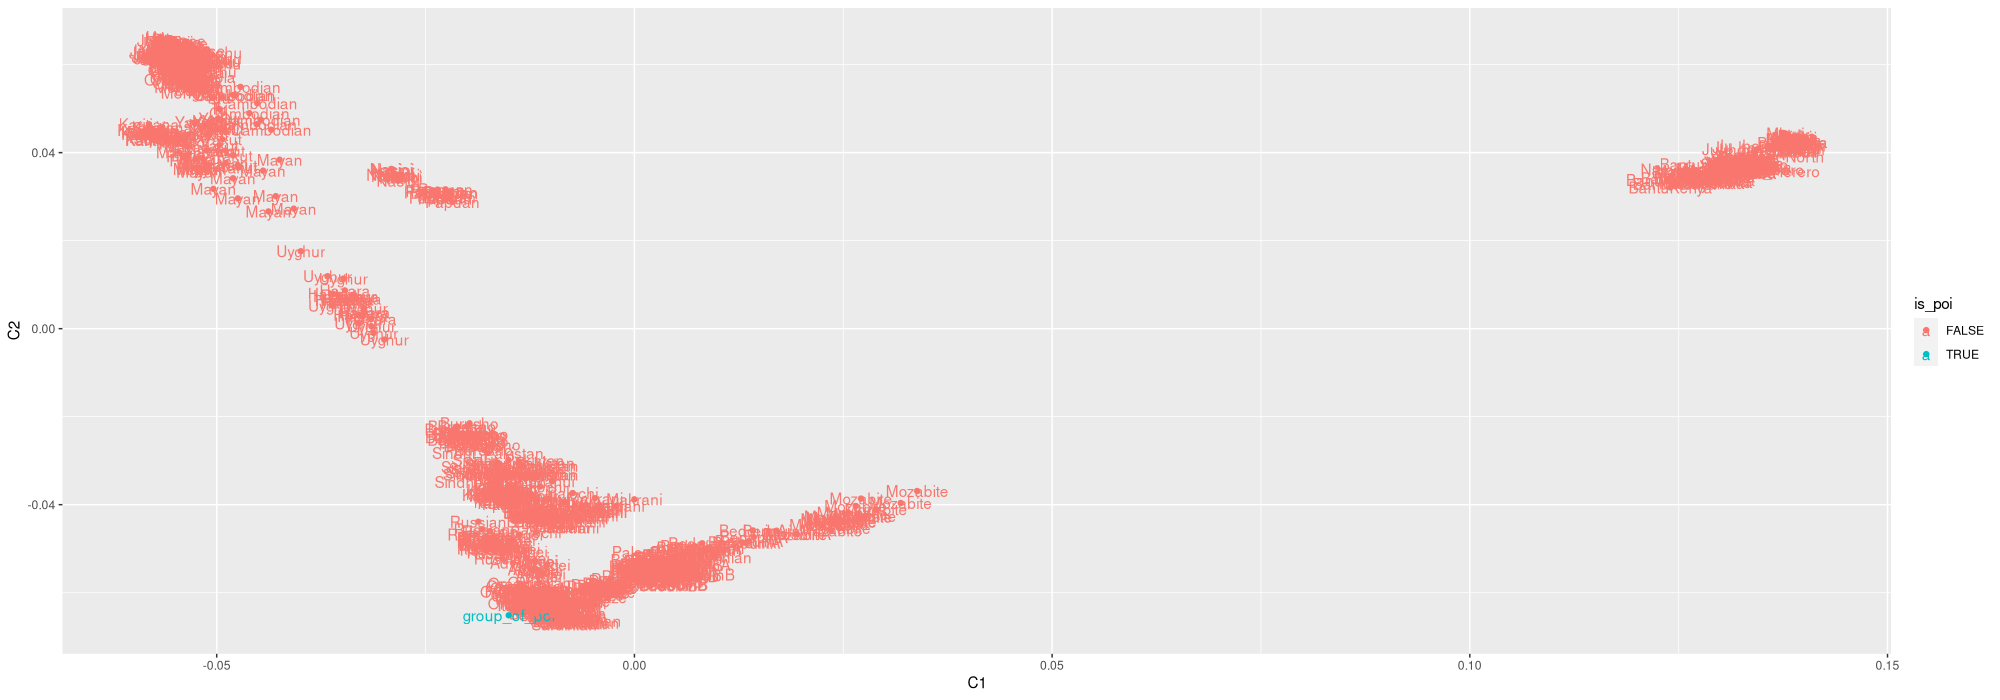

In [22]:
library(ggplot2)
options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 100)

mds %>%
dplyr::mutate(
    is_poi = IID == "poi"
) %>% 
ggplot() +
geom_text(aes(x = C1, y = C2, color = is_poi, label = FID)) +
geom_point(aes(x = C1, y = C2, color = is_poi))

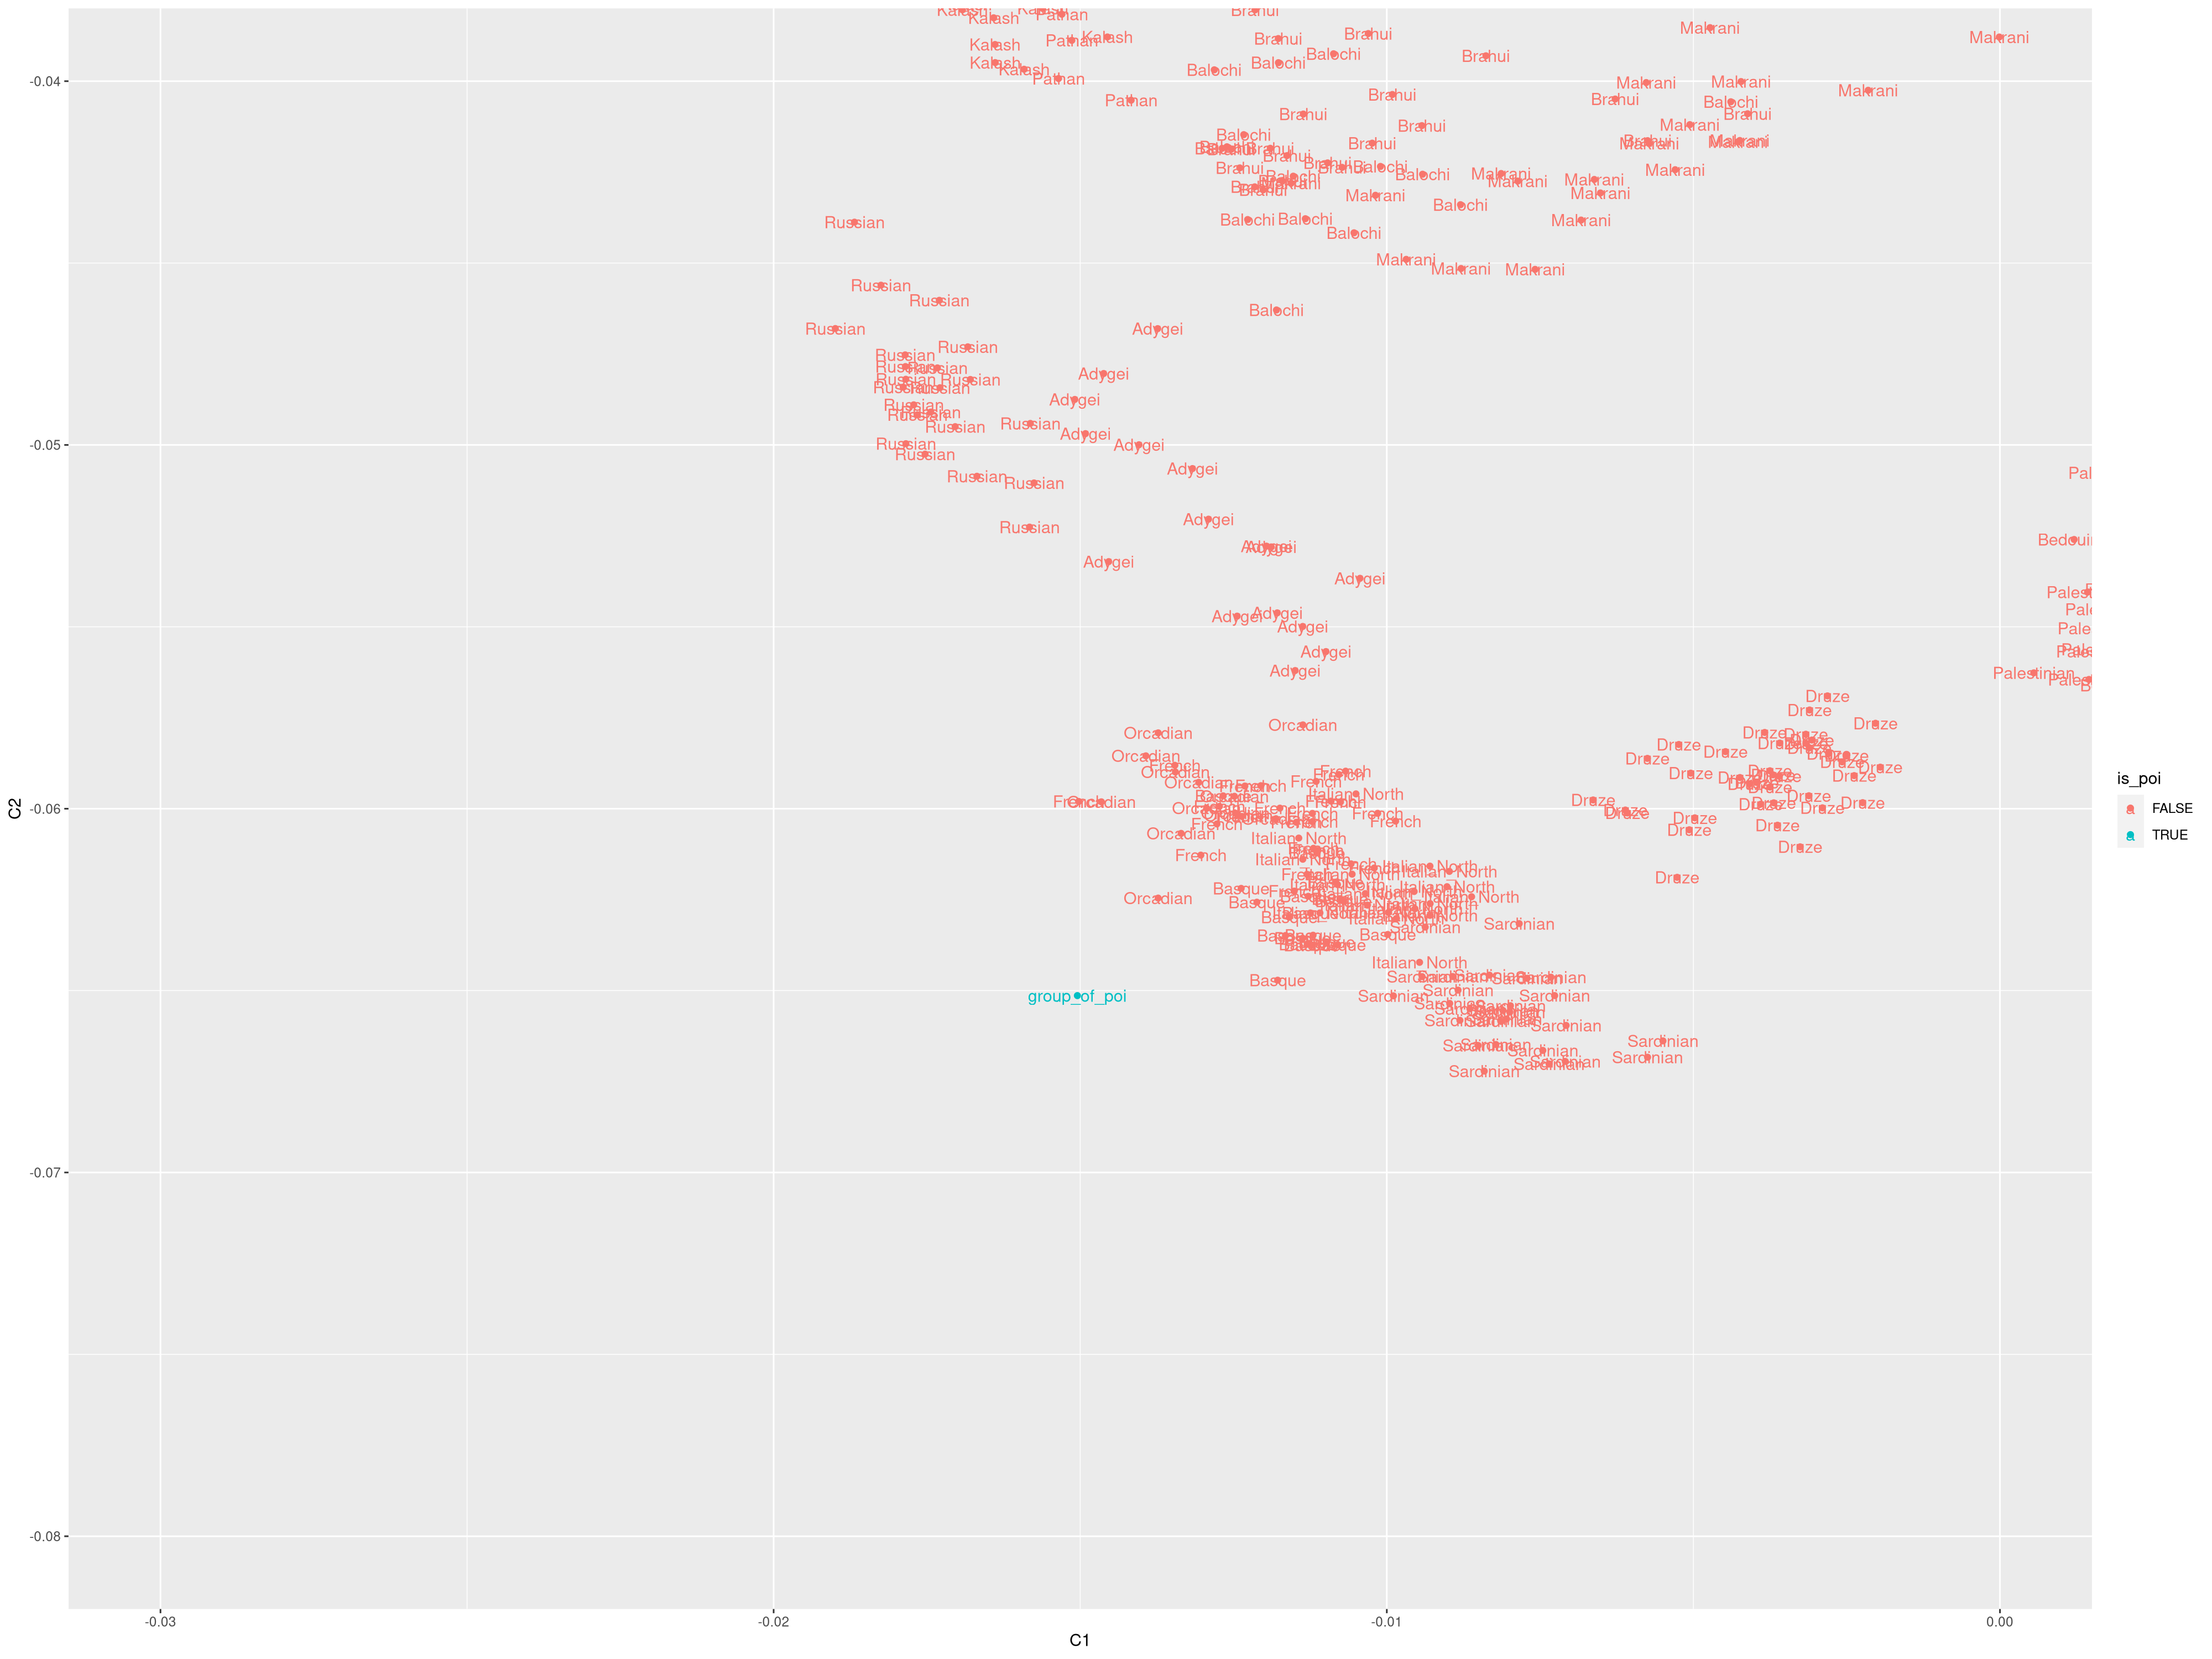

In [26]:
library(ggplot2)
options(repr.plot.width = 20, repr.plot.height = 15, repr.plot.res = 200)

mds %>%
dplyr::mutate(
    is_poi = IID == "poi"
) %>% 
ggplot() +
geom_text(aes(x = C1, y = C2, color = is_poi, label = FID)) +
geom_point(aes(x = C1, y = C2, color = is_poi)) +
coord_cartesian(xlim = c(-0.03, 0), ylim=c(-0.08,-0.04))